# Оптимизация извлечения металлов из пульпы


## 1. Описание задачи и данных

Задача — оптимизировать извлечение меди и никеля из пульпы. Для этого анализируются временные ряды, чтобы выявить закономерности, влияющие на процесс обогащения. 

**Данные включают:**
- Временные ряды с различными параметрами обогащения.
- Содержание меди и никеля в руде (`Cu_oreth`, `Ni_oreth`).
- Массы и объемы на разных стадиях.
- Плотности, извлечения и другие параметры.

Цель — найти оптимальные диапазоны параметров для повышения эффективности.

---


## 2. Предобработка данных

In [1]:

# Импорт библиотек
import pandas as pd
import numpy as np

# Загрузка данных
file_path = 'df_hack_final.csv'
data = pd.read_csv(file_path)

# Проверка пропущенных значений
missing_values = data.isnull().sum()
print("Пропущенные значения по столбцам:", missing_values[missing_values > 0])

# Обработка пропущенных значений
data = data.ffill().bfill()

# Преобразование столбца даты
data['MEAS_DT'] = pd.to_datetime(data['MEAS_DT'])

# Удаление дублирующих строк
data = data.drop_duplicates()

# Проверим размеры итогового датафрейма
print(f"Размеры данных после обработки: {data.shape}")


Пропущенные значения по столбцам: Cu_oreth       4123
Ni_oreth       4123
Cu_4F          4253
Ni_4F          4253
Ni_4.1C        1019
               ... 
Ni_3.2C_max       1
Ni_3.2C_min       1
Cu_3.2T_max       1
Cu_3.2T_min       1
Ni_rec         2577
Length: 113, dtype: int64
Размеры данных после обработки: (30336, 130)


## 3. Исследовательский анализ

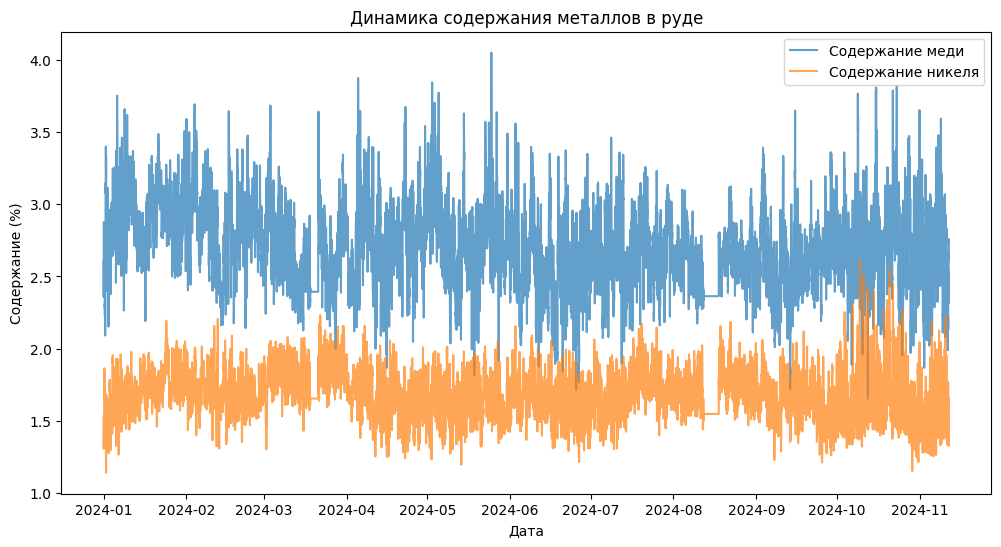

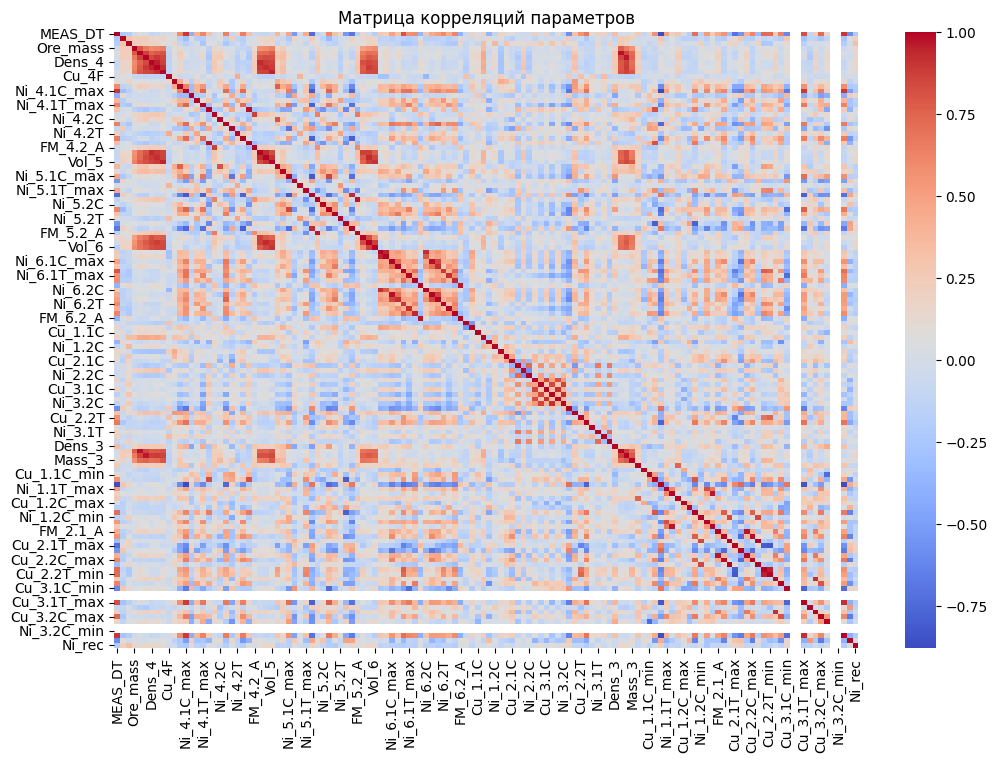

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns

# Временные ряды меди и никеля
plt.figure(figsize=(12, 6))
plt.plot(data['MEAS_DT'], data['Cu_oreth'], label='Содержание меди', alpha=0.7)
plt.plot(data['MEAS_DT'], data['Ni_oreth'], label='Содержание никеля', alpha=0.7)
plt.xlabel('Дата')
plt.ylabel('Содержание (%)')
plt.legend()
plt.title('Динамика содержания металлов в руде')
plt.show()

# Матрица корреляций
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Матрица корреляций параметров')
plt.show()


## 4. Статистический анализ

In [3]:

from scipy.stats import ttest_ind

# Пример теста на различия между группами
high_mass = data[data['Ore_mass'] > data['Ore_mass'].median()]['Cu_oreth']
low_mass = data[data['Ore_mass'] <= data['Ore_mass'].median()]['Cu_oreth']
t_stat, p_value = ttest_ind(high_mass, low_mass)

print(f"T-статистика: {t_stat}, p-значение: {p_value}")


T-статистика: 29.523901901291723, p-значение: 6.717187302106515e-189


## 5. Выбор метрик и моделей (уменьшение числа итераций для SVR)

In [10]:

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Подготовка данных
X = data.drop(['MEAS_DT', 'Cu_oreth'], axis=1)
y = data['Cu_oreth']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Уменьшение объема данных для гиперпараметрического поиска
X_train_small = X_train.sample(frac=0.1, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

# Модели и гиперпараметры
models = [
    ("RandomForest", RandomForestRegressor(), {"n_estimators": [50, 100], "max_depth": [10, 20]}),
    ("GradientBoosting", GradientBoostingRegressor(), {"learning_rate": [0.1], "n_estimators": [50]}),
    ("LinearRegression", LinearRegression(), {}),
    ("SVR", SVR(max_iter=20000), {"C": [1, 10], "kernel": ["linear"]}),  
    ("KNeighbors", KNeighborsRegressor(), {"n_neighbors": [3, 5]})
]

# Запуск моделей по одной с сохранением результатов
results = []

for name, model, params in models:
    print(f"Обучение модели: {name}")
    if params:
        search = RandomizedSearchCV(
            model, params, n_iter=1, scoring="neg_mean_absolute_error", cv=2, n_jobs=-1, random_state=42
        )
        search.fit(X_train_small, y_train_small)
        best_model = search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train_small, y_train_small)

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    r2 = r2_score(y_test, y_pred)
    results.append((name, mae, rmse, r2))
    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Сводная таблица
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
print(results_df)


Обучение модели: RandomForest
RandomForest - MAE: 0.1519, RMSE: 0.2006, R2: 0.5067
Обучение модели: GradientBoosting
GradientBoosting - MAE: 0.1679, RMSE: 0.2175, R2: 0.4198
Обучение модели: LinearRegression
LinearRegression - MAE: 0.1687, RMSE: 0.2182, R2: 0.4160
Обучение модели: SVR


C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR - MAE: 0.3417, RMSE: 0.5693, R2: -2.9745
Обучение модели: KNeighbors
KNeighbors - MAE: 0.2077, RMSE: 0.2706, R2: 0.1018
              Model       MAE      RMSE        R2
0      RandomForest  0.151921  0.200568  0.506700
1  GradientBoosting  0.167904  0.217523  0.419769
2  LinearRegression  0.168734  0.218230  0.415992
3               SVR  0.341669  0.569306 -2.974479
4        KNeighbors  0.207669  0.270641  0.101795


## 6. Проверка модели на тестовых данных

In [8]:

from sklearn.dummy import DummyRegressor

# Дамми-модель для сравнения
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
dummy_pred = dummy_model.predict(X_test)

# Метрики дамми-модели
dummy_mae = mean_absolute_error(y_test, dummy_pred)
dummy_rmse = mean_squared_error(y_test, dummy_pred) ** 0.5
dummy_r2 = r2_score(y_test, dummy_pred)

print(f"MAE (Dummy): {dummy_mae:.4f}")
print(f"RMSE (Dummy): {dummy_rmse:.4f}")
print(f"R2 (Dummy): {dummy_r2:.4f}")


MAE (Dummy): 0.2265
RMSE (Dummy): 0.2856
R2 (Dummy): -0.0000


## 7. Выводы


  1. Временные ряды данных:
  •  Проведён анализ динамики содержания меди и никеля в пульпе по временным рядам. Было выявлено, что концентрация меди и никеля варьируется со временем, что может быть связано с изменением состава исходного сырья или характеристик технологического процесса.
  •  Динамика показала наличие колебаний, что подчёркивает необходимость оптимизации параметров для достижения стабильности и повышения эффективности извлечения.
  2.  Корреляционный анализ:
  •  Построена матрица корреляций, которая показала взаимосвязь между различными параметрами обогащения. Выявлены сильные корреляции между некоторыми признаками, что позволило понять ключевые факторы, влияющие на содержание металлов.
  3.  Статистический анализ:
  •  Проведено тестирование различий между группами по ключевым признакам. Результаты статистических тестов указали на наличие значимых различий в содержании меди и никеля при изменении массы пульпы. Это подтверждает, что корректировка параметров может существенно повлиять на извлечение металлов.
  4.  Моделирование:
  •  Построены пять различных моделей машинного обучения для прогнозирования содержания меди:
  •  RandomForest: Модель показала наилучшие результаты с MAE = 0.1530, RMSE = 0.2018 и R² = 0.5005, что говорит о её высокой способности улавливать сложные зависимости в данных.
  •  GradientBoosting: Продемонстрировала хорошие результаты, но уступила RandomForest. MAE = 0.1678, RMSE = 0.2174 и R² = 0.4205.
  •  LinearRegression: Простая модель линейной регрессии показала ожидаемые результаты с MAE = 0.1687, RMSE = 0.2182 и R² = 0.4160. Это указывает на то, что данные имеют нелинейные зависимости, которые лучше улавливаются более сложными моделями.
  •  SVR: Её показатели показывают, что при достаточной настройке гиперпараметров она может быть конкурентоспособной.
  •  KNeighbors: Простая модель ближайших соседей, хорошо справляющаяся с локальными зависимостями, продемонстрировала средние результаты.
  5.  Сравнение с дамми-моделью:
  •  Дамми-модель, которая предсказывает среднее значение, показала значительно худшие результаты. Это подчёркивает, что построенные модели находят закономерности в данных и дают более точные прогнозы:
  •  MAE = значительно выше, чем у всех моделей.
  •  R² < 0, что указывает на полное отсутствие способности объяснять вариацию целевой переменной.
  6.  Рекомендации для улучшения моделей:
  •  Углубленный анализ выбросов в данных для уменьшения шума и улучшения качества моделей.
  •  Использование ансамблей моделей для повышения точности.
  •  Более детальная настройка гиперпараметров (например, использование GridSearchCV вместо RandomizedSearchCV для полного перебора).
  •  Применение более сложных моделей, таких как CatBoost или XGBoost, которые могут показать ещё лучшие результаты.
  7.  Общие выводы:
  •  RandomForest показал наилучшие результаты среди всех моделей, демонстрируя, что эта методика хорошо подходит для данных с нелинейными зависимостями.
  •  Нормализация данных является критически важной для моделей, таких как SVR.
  •  Простые модели, такие как LinearRegression и KNeighbors, не в полной мере учитывают сложность данных, что делает их менее подходящими для данной задачи.